In [3]:
# Import necessary libraries

# Data manipulation
import pandas as pd
import numpy as np

# For scaling and standardization
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# For PCA (Principal Component Analysis)
from sklearn.decomposition import PCA

# For statistical analysis
from scipy import stats
from scipy.stats import skew, kurtosis, shapiro, normaltest, probplot

# For time series analysis (ACF and PACF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Ensure inline plotting if you're using Jupyter notebooks (remove if not needed)
%matplotlib inline

In [4]:
# Load the cleaned DataFrame from the CSV file
df = pd.read_csv('df.csv')

In [5]:
# Check number of stores in dataset

df['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

# One-Hot Encoding Store Variable

In [6]:
# One-hot encoding for store variable

# Creating the encoder instance
encoder = OneHotEncoder()

# Reshape(-1, 1) because the encoder expects a 2D array
encoded_features = encoder.fit_transform(df[['Store']])

# Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(['Store']))

# Concatenate the original DataFrame with the new one
df = pd.concat([df, encoded_df], axis=1).drop('Store', axis=1)

print(df)

            Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0     2010-02-05    1643690.90             0        42.31       2.572   
1     2010-02-12    1641957.44             1        38.51       2.548   
2     2010-02-19    1611968.17             0        39.93       2.514   
3     2010-02-26    1409727.59             0        46.63       2.561   
4     2010-03-05    1554806.68             0        46.50       2.625   
...          ...           ...           ...          ...         ...   
6430  2012-09-28     713173.95             0        64.88       3.997   
6431  2012-10-05     733455.07             0        64.89       3.985   
6432  2012-10-12     734464.36             0        54.47       4.000   
6433  2012-10-19     718125.53             0        56.47       3.969   
6434  2012-10-26     760281.43             0        58.85       3.882   

             CPI  Unemployment  Store_1  Store_2  Store_3  ...  Store_36  \
0     211.096358         8.106      1.0      0.

# Transformation and Standardization

In [8]:
columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

def transform_data(df, columns):
    # Create a new DataFrame for transformations
    df_transformed = df[columns].copy()

    # Apply log transformation to Weekly_Sales and Unemployment
    df_transformed['Weekly_Sales'] = np.log(df_transformed['Weekly_Sales'] + 1)
    df_transformed['Unemployment'] = np.log(df_transformed['Unemployment'] + 1)

    # Standardize Temperature, Fuel_Price, CPI, Weekly_Sales, and Unemployment
    scaler = StandardScaler()
    columns_to_standardize = ['Temperature', 'Fuel_Price', 'CPI', 'Weekly_Sales', 'Unemployment']
    df_transformed[columns_to_standardize] = scaler.fit_transform(df_transformed[columns_to_standardize])

    return df_transformed

# Example usage
df_transformed = transform_data(df, columns)
df_transformed.to_csv('processed_data.csv', index=False)
print(df_transformed.head())

   Weekly_Sales  Temperature  Fuel_Price       CPI  Unemployment
0      1.037892    -0.995136   -1.713800  1.004175      0.160732
1      1.036099    -1.201170   -1.766089  1.007880      0.160732
2      1.004763    -1.124178   -1.840166  1.009074      0.160732
3      0.776870    -0.760907   -1.737766  1.009849      0.160732
4      0.943387    -0.767955   -1.598328  1.010624      0.160732


# Principal Component Analysis

In [9]:
def apply_pca(df_transformed, target_column, variance_threshold=0.95):
    X_transformed = df_transformed.drop(columns=[target_column])
    y_transformed = df_transformed[target_column]
    pca = PCA(n_components=variance_threshold)
    X_pca = pca.fit_transform(X_transformed)

    # Create a DataFrame with the principal components
    pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    df_pca = pd.DataFrame(X_pca, columns=pca_columns)
    df_pca[target_column] = y_transformed.reset_index(drop=True)

    return df_pca

target_column = 'Weekly_Sales'
df_pca = apply_pca(df_transformed, target_column)
df_pca.to_csv('pca_data.csv', index=False)
print(df_pca.head())

        PC1       PC2       PC3       PC4  Weekly_Sales
0  0.961774 -1.715893  0.961484  0.409704      1.037892
1  0.947336 -1.907820  0.911642  0.485001      1.036099
2  0.978688 -1.893669  0.987601  0.418192      1.004763
3  1.007084 -1.548199  1.070854  0.294233      0.776870
4  0.970882 -1.467441  0.983626  0.357891      0.943387


# Visualization: Original vs Transformed Data

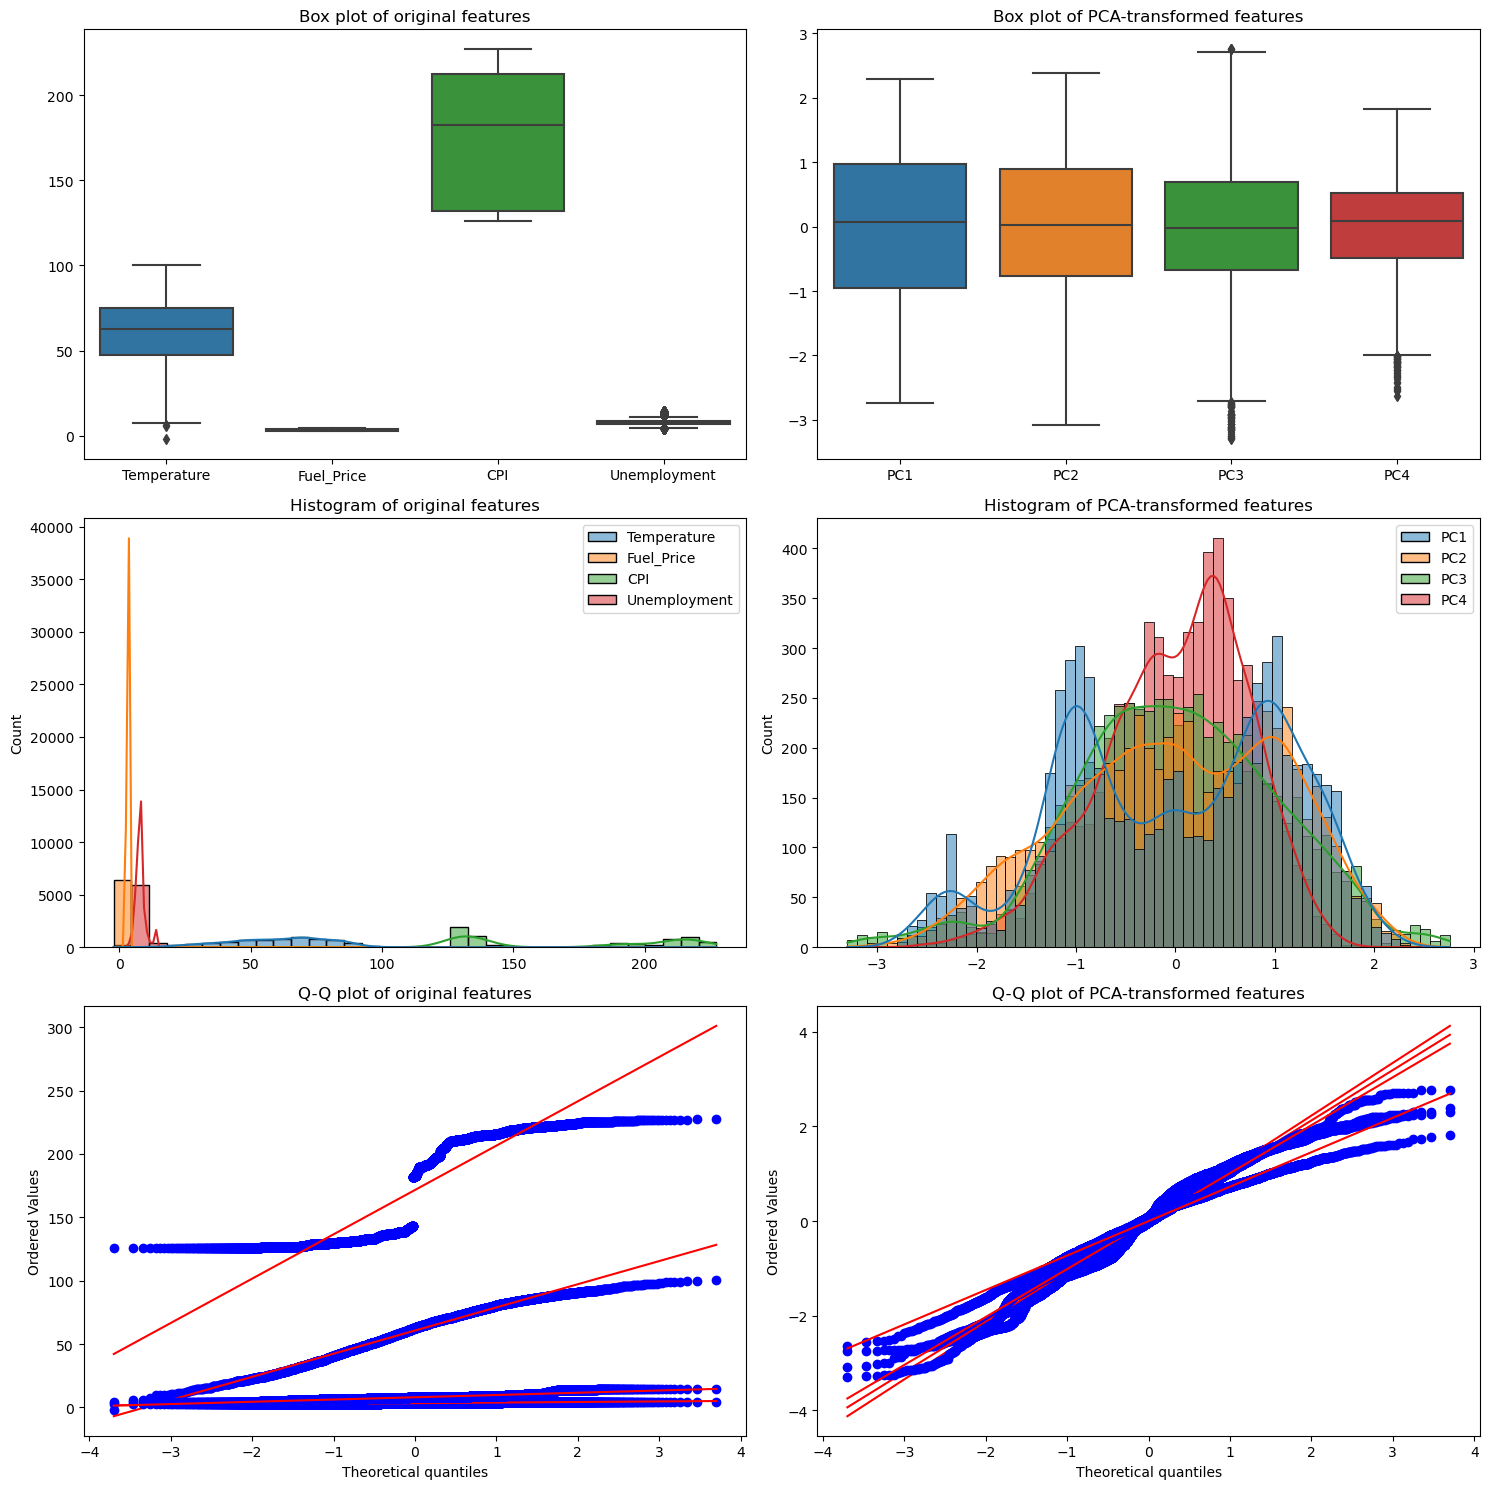

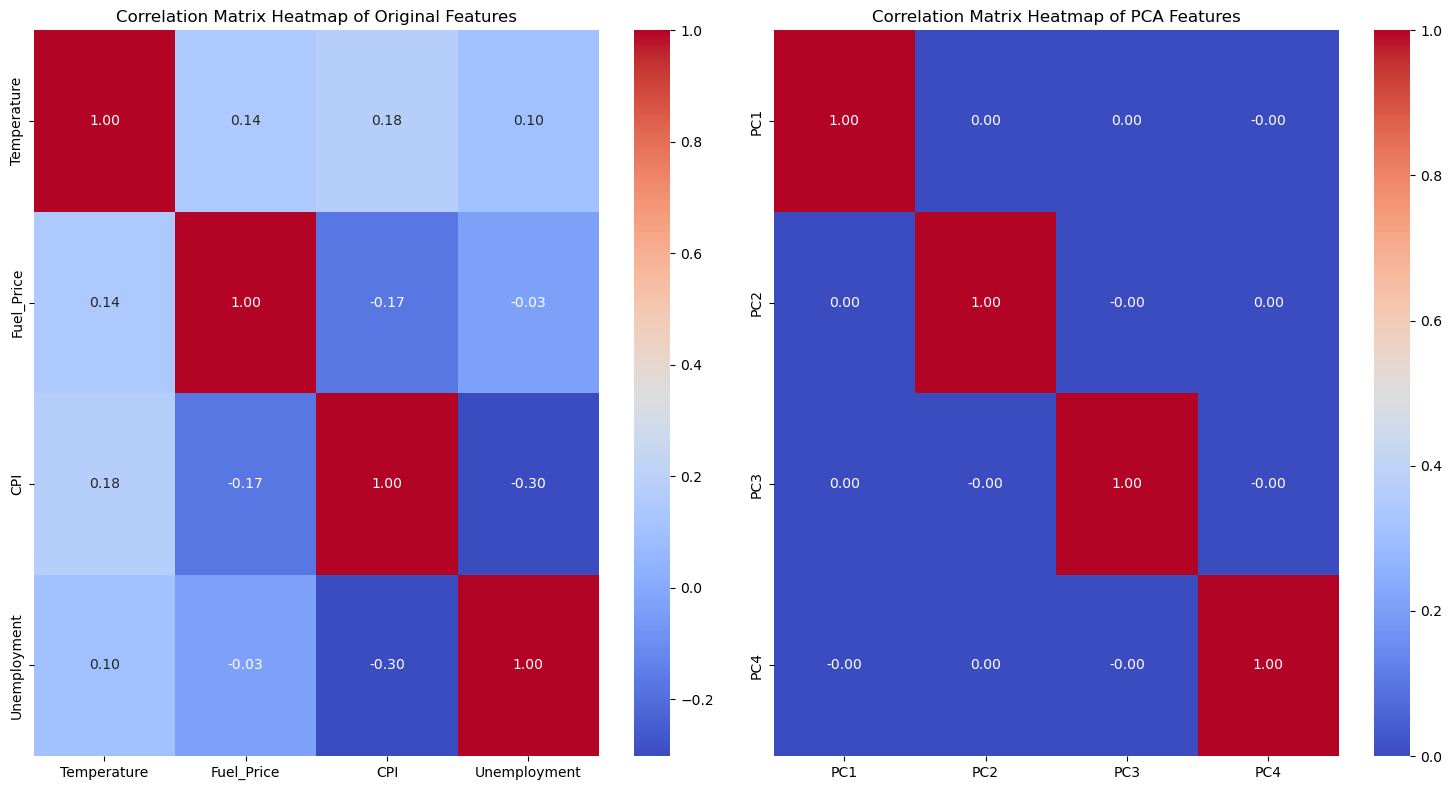

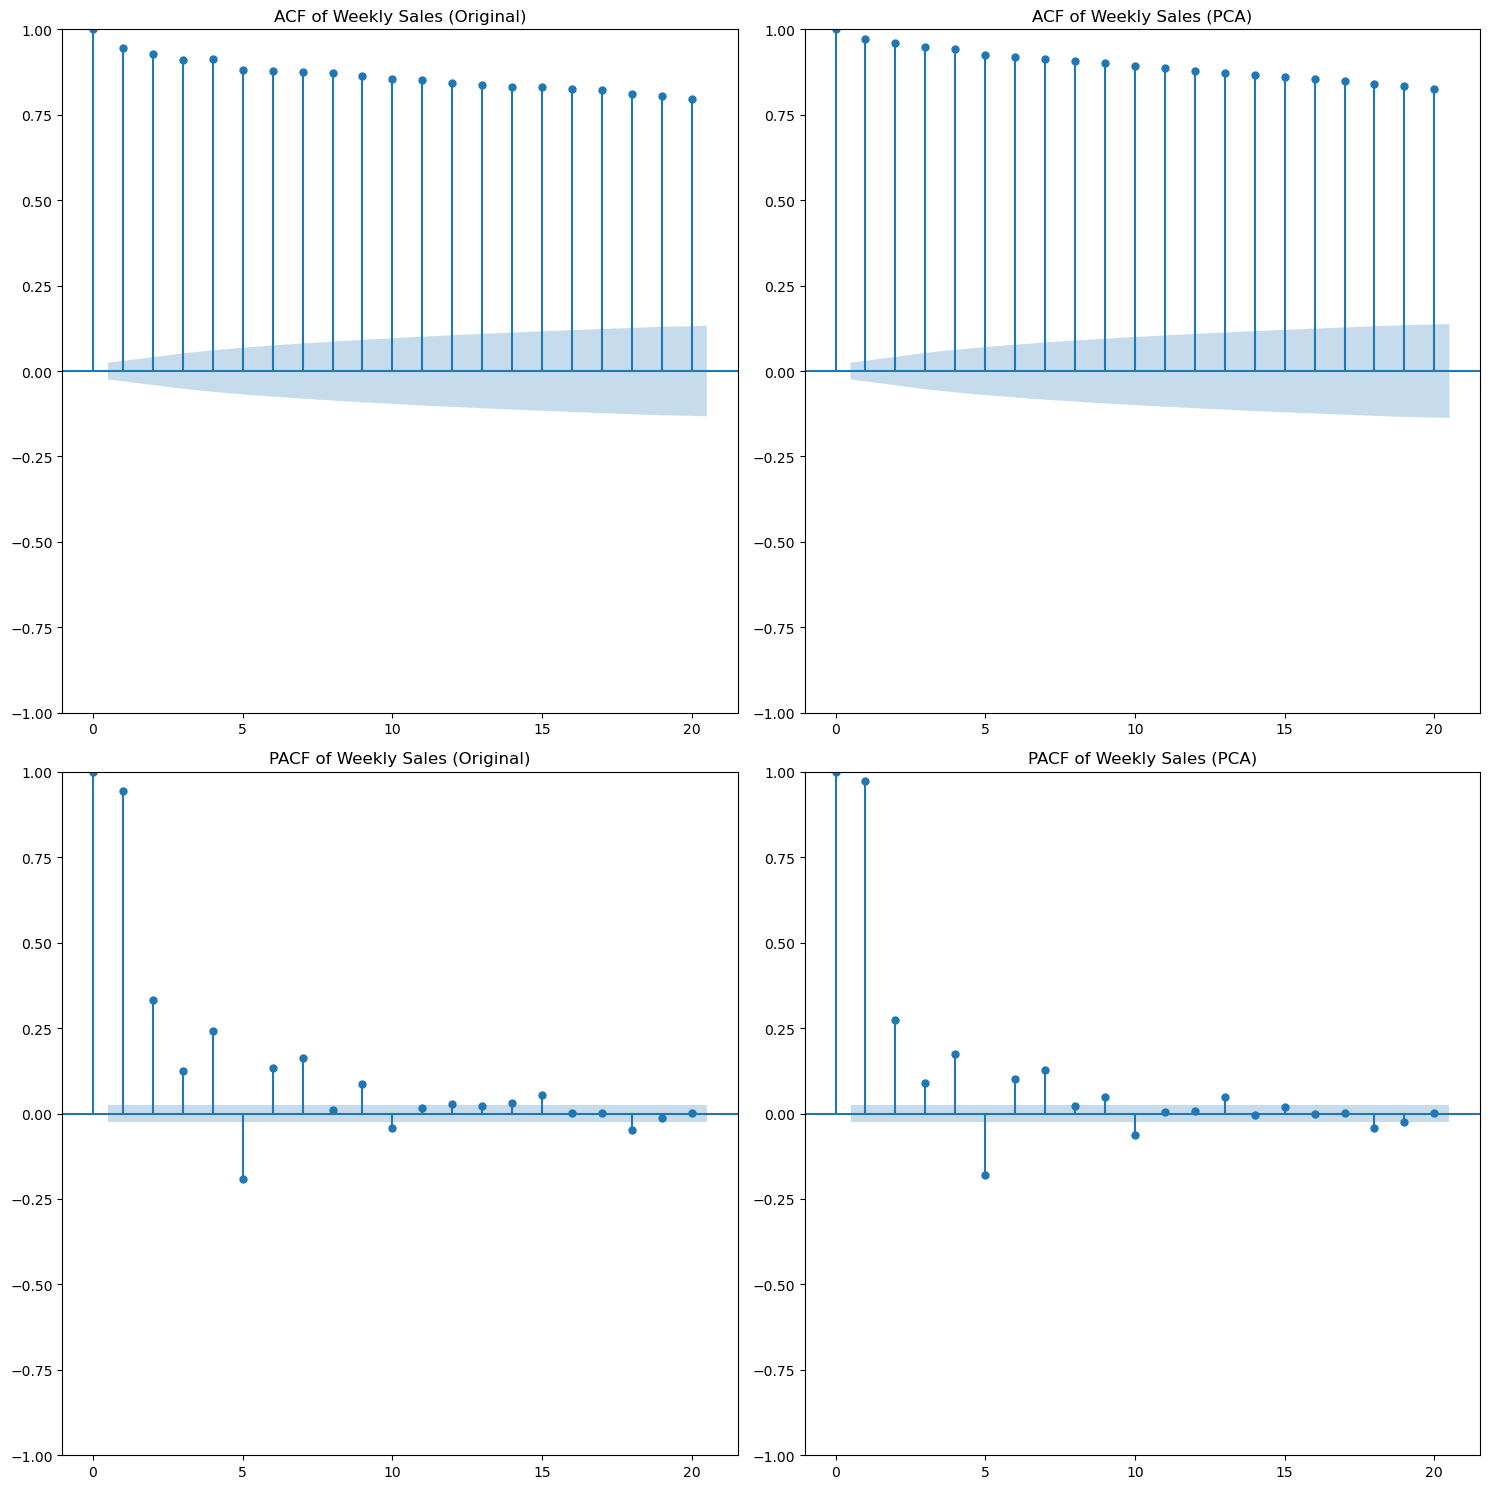

In [10]:
def plot_comparison(df, df_pca, target_column):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))

    # Box plots for visual inspection of outliers
    sns.boxplot(data=df.drop(columns=[target_column]), ax=axes[0, 0])
    axes[0, 0].set_title('Box plot of original features')

    sns.boxplot(data=df_pca.drop(columns=[target_column]), ax=axes[0, 1])
    axes[0, 1].set_title('Box plot of PCA-transformed features')

    # Histograms to check the distribution
    sns.histplot(data=df.drop(columns=[target_column]), kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Histogram of original features')

    sns.histplot(data=df_pca.drop(columns=[target_column]), kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Histogram of PCA-transformed features')

    # Q-Q plots for normality check
    for col in df.drop(columns=[target_column]).columns:
        probplot(df[col].dropna(), dist="norm", plot=axes[2, 0])
    axes[2, 0].set_title('Q-Q plot of original features')

    for col in df_pca.drop(columns=[target_column]).columns:
        probplot(df_pca[col].dropna(), dist="norm", plot=axes[2, 1])
    axes[2, 1].set_title('Q-Q plot of PCA-transformed features')

    plt.tight_layout()
    plt.show()

    # Correlation matrix heatmap
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    correlation_matrix_original = df.drop(columns=[target_column]).corr()
    sns.heatmap(correlation_matrix_original, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[0])
    axes[0].set_title('Correlation Matrix Heatmap of Original Features')

    correlation_matrix_pca = df_pca.drop(columns=[target_column]).corr()
    sns.heatmap(correlation_matrix_pca, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1])
    axes[1].set_title('Correlation Matrix Heatmap of PCA Features')

    plt.tight_layout()
    plt.show()

    # ACF and PACF plots for 'Weekly_Sales'
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    plot_acf(df[target_column].dropna(), ax=axes[0, 0], lags=20)
    axes[0, 0].set_title('ACF of Weekly Sales (Original)')

    plot_pacf(df[target_column].dropna(), ax=axes[1, 0], lags=20)
    axes[1, 0].set_title('PACF of Weekly Sales (Original)')

    plot_acf(df_pca[target_column].dropna(), ax=axes[0, 1], lags=20)
    axes[0, 1].set_title('ACF of Weekly Sales (PCA)')

    plot_pacf(df_pca[target_column].dropna(), ax=axes[1, 1], lags=20)
    axes[1, 1].set_title('PACF of Weekly Sales (PCA)')

    plt.tight_layout()
    plt.show()

plot_comparison(df[columns], df_pca, 'Weekly_Sales')

In [12]:
df_pca.head()

,PC1,PC2,PC3,PC4,Weekly_Sales
0,0.961774,-1.715893,0.961484,0.409704,1.037892
1,0.947336,-1.907820,0.911642,0.485001,1.036099
2,0.978688,-1.893669,0.987601,0.418192,1.004763
3,1.007084,-1.548199,1.070854,0.294233,0.776870
4,0.970882,-1.467441,0.983626,0.357891,0.943387


# Prepare Dataframe for Prediction Model Application

In [ ]:
# Ensure that the 'Date' column is in datetime format
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], errors='coerce')  # Convert to datetime

# Add Month column
df_cleaned['Month'] = df_cleaned['Date'].dt.month

# Merge df_cleaned with df_pca using suffixes to handle overlapping columns
df_pca_combined = df_pca.join(df_cleaned, how='inner', lsuffix='_pca', rsuffix='_cleaned')

# Now df_pca_combined includes PCA components, the holiday flag, and the one-hot encoded variables
df_pca_combined = df_pca_combined.reset_index(drop=True)

# Remove the Date column
df_pca_combined = df_pca_combined.drop(columns=['Date'])

# Remove outliers for PC3 and PC4
df_pca_combined = remove_outliers_zscore(df_pca_combined, ['PC3', 'PC4'])

print(df_pca_combined)


In [14]:
# Function to remove outliers based on Z-score for specified columns
def remove_outliers_zscore(df, columns, threshold=3):
    z_scores = np.abs(stats.zscore(df[columns]))
    df_cleaned = df[(z_scores < threshold).all(axis=1)]
    return df_cleaned

# Ensure that the 'Date' column is in datetime format in the original DataFrame
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop unnecessary columns from df, keeping only the date, holiday flag, and one-hot encoded columns
columns_to_keep = ['Date', 'Holiday_Flag']  # Start with the Date and Holiday_Flag columns
encoded_columns = [col for col in df.columns if col.startswith('Store_')]  # Add encoded columns
columns_to_keep.extend(encoded_columns)

df_cleaned = df[columns_to_keep]

# Add Day_of_Week and Month columns
df_cleaned['Month'] = df_cleaned['Date'].dt.month
df_cleaned['Day_of_Week'] = df_cleaned['Date'].dt.dayofweek

# Merge df_cleaned with df_pca using suffixes to handle overlapping columns
df_pca_combined = df_pca.join(df_cleaned, how='inner', lsuffix='_pca', rsuffix='_cleaned')

# Now df_pca_combined includes PCA components, the holiday flag, and the one-hot encoded variables
df_pca_combined = df_pca_combined.reset_index(drop=True)

# Remove the Date column (since it's no longer needed in df_pca_combined)
df_pca_combined = df_pca_combined.drop(columns=['Date'])

# Remove outliers for PC3 and PC4
df_pca_combined = remove_outliers_zscore(df_pca_combined, ['PC3', 'PC4'])

print(df_pca_combined)

           PC1       PC2       PC3       PC4  Weekly_Sales  Holiday_Flag  \
0     0.961774 -1.715893  0.961484  0.409704      1.037892             0   
1     0.947336 -1.907820  0.911642  0.485001      1.036099             1   
2     0.978688 -1.893669  0.987601  0.418192      1.004763             0   
3     1.007084 -1.548199  1.070854  0.294233      0.776870             0   
4     0.970882 -1.467441  0.983626  0.357891      0.943387             0   
...        ...       ...       ...       ...           ...           ...   
6430 -0.199428  1.121562 -0.334195  1.033465     -0.381514             0   
6431 -0.184511  1.105683 -0.323036  1.020104     -0.333846             0   
6432 -0.273926  0.687530 -0.567820  1.298506     -0.331509             0   
6433 -0.240408  0.730026 -0.483492  1.219259     -0.369752             0   
6434 -0.173042  0.713073 -0.317063  1.077635     -0.272781             0   

      Store_1  Store_2  Store_3  Store_4  ...  Store_38  Store_39  Store_40  \
0       

In [15]:
df_pca_combined.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'Weekly_Sales', 'Holiday_Flag', 'Store_1',
       'Store_2', 'Store_3', 'Store_4', 'Store_5', 'Store_6', 'Store_7',
       'Store_8', 'Store_9', 'Store_10', 'Store_11', 'Store_12', 'Store_13',
       'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18', 'Store_19',
       'Store_20', 'Store_21', 'Store_22', 'Store_23', 'Store_24', 'Store_25',
       'Store_26', 'Store_27', 'Store_28', 'Store_29', 'Store_30', 'Store_31',
       'Store_32', 'Store_33', 'Store_34', 'Store_35', 'Store_36', 'Store_37',
       'Store_38', 'Store_39', 'Store_40', 'Store_41', 'Store_42', 'Store_43',
       'Store_44', 'Store_45', 'Month', 'Day_of_Week'],
      dtype='object')

In [16]:
# Save the DataFrame as a CSV file
df_pca_combined.to_csv('df_pca_combined.csv', index=False)  # index=False to avoid writing row numbers to the file